# Learning curves

In [1]:
from load_data import load
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import numpy as np

## Load data

In [2]:
(df, diff, dataX, dataY) = load()

0        True
1        True
2        True
3        True
4        True
        ...  
2208    False
2209    False
2210    False
2211    False
2212    False
Name: Pressure (bar), Length: 2213, dtype: bool
2213


## Implement the ACC_regr

In [3]:
def calc_accuracy(pred_val, real_val, thr):
    N = len(pred_val)
    return (N + np.sum(np.sign((pred_val-thr)*(real_val-thr))))/(2*N)

## Implement 3 data splits 

### 1) material-pressure-speed configuration split

In [4]:
#test/train split - configuration: material-speed-pressure
def split_data(ppf, speed, pressure, dataX, dataY):
    cond1 = df["wt% PPF"]==ppf
    cond2 = df["Pressure (bar)"]==pressure
    cond3 = df["Speed (mm/s)"]==speed

    cond1=cond1.to_numpy()
    cond2=cond2.to_numpy()
    cond3=cond3.to_numpy()
    
    c = [c1 and cond2[i] and cond3[i] for i, c1 in enumerate(cond1)]
    nc = [not (c1 and cond2[i] and cond3[i]) for i, c1 in enumerate(cond1)]
    X_test = dataX[c]
    X_train = dataX[nc]

    y_test = dataY[c]
    y_train = dataY[nc]
    return (X_test, X_train, y_test, y_train)

### 2) material-pressure-speed-spacing configuration split

In [5]:
#test/train split - fixed spacing! 
def split_data_s(ppf, speed, pressure, dataX, dataY, spac):
    cond1 = df["wt% PPF"]==ppf
    cond2 = df["Pressure (bar)"]==pressure
    cond3 = df["Speed (mm/s)"]==speed
    cond4 = df["Spacing (mm)"]==spac
    
    cond1=cond1.to_numpy()
    cond2=cond2.to_numpy()
    cond3=cond3.to_numpy()
    cond4=cond4.to_numpy()
    
    c = [c1 and cond2[i] and cond3[i] and cond4[i] for i, c1 in enumerate(cond1)]
    nc = [not (c1 and cond2[i] and cond3[i]) and cond4[i] for i, c1 in enumerate(cond1)]
    X_test = dataX[c]
    X_train = dataX[nc]

    y_test = dataY[c]
    y_train = dataY[nc]
    return (X_test, X_train, y_test, y_train)

### 3) material-pressure-speed-spacing-layer configuration split

In [6]:
#test/train split - fixed spacing and fixed layer!
def split_data_sl(ppf, speed, pressure, dataX, dataY, spac, layer):
    cond1 = df["wt% PPF"]==ppf
    cond2 = df["Pressure (bar)"]==pressure
    cond3 = df["Speed (mm/s)"]==speed
    cond4 = df["Spacing (mm)"]==spac
    cond5 = df["Layer #"]==layer

    cond1=cond1.to_numpy()
    cond2=cond2.to_numpy()
    cond3=cond3.to_numpy()
    cond4=cond4.to_numpy()
    cond5=cond5.to_numpy()
    
    c = [c1 and cond2[i] and cond3[i] and cond4[i] and cond5[i] for i, c1 in enumerate(cond1)]
    nc = [not (c1 and cond2[i] and cond3[i]) and cond4[i] and cond5[i] for i, c1 in enumerate(cond1)]
    X_test = dataX[c]
    X_train = dataX[nc]

    y_test = dataY[c]
    y_train = dataY[nc]
    return (X_test, X_train, y_test, y_train)

## Formulate the training loops for all 3 data splits 

In [7]:
from random import randrange

def train(leftover_proc = 1):
    
    # leave one out, create all combinations
    combos_spp = df[["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]].groupby(["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]).size().reset_index()
    combos = combos_spp[["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]].values
    accus = []
    labels_true = []
    values_true = []
    values_pred = []
    train_num = 0
    #for doing the experiment on one configuration only - 85-5mm/s-2bar
    #combos = [combos[0]] #
    
    for combo in combos:
        (X_test, X_train, y_test, y_train) = split_data(combo[2],combo[0],combo[1],dataX, dataY)
        #throw an error if no data in test or train
        if len(X_test)==0 or len(X_train)==0:
            print(combo)
            print("no_data")
            continue
        #remove part of the training - training incrementally
        num_to_remove = int((1 - leftover_proc)*len(y_train))
        x_train = list(X_train.values)
        y1_train = list(y_train.values[:,1])
        y0_train = list(y_train.values[:,0])
        for i in range(num_to_remove):
            if len(y1_train) == 0:
                break
            to_rem = randrange(len(y1_train))
            del y1_train[to_rem]
            del y0_train[to_rem]
            del x_train[to_rem]
            
        train_num += len(x_train)
        regr = RandomForestRegressor(max_depth=6, random_state=0,n_estimators=100)
        regr.fit(x_train, y1_train)
        y_pred_material =  regr.predict(X_test.values)
        acc = calc_accuracy(y_pred_material, y_test.values[:,1], 50)
        accus.append(acc)

    train_num/=len(combos)
    return np.average(np.array(accus), axis = 0), train_num

In [8]:
from random import randrange

def train_s(leftover_proc, spac):
    # leave one out, create all combinations
    combos_spp = df[["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]].groupby(["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]).size().reset_index()
    combos = combos_spp[["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]].values
    accus = []
    labels_true = []
    values_true = []
    values_pred = []
    train_num = 0
    #for lookint into one combo- 85-5mm/s-2bar
    #combos= [combos[0]]
    for combo in combos:
        (X_test, X_train, y_test, y_train) = split_data_s(combo[2],combo[0],combo[1],dataX, dataY, spac)
        
        if len(X_test)==0 or len(X_train)==0:
            print(combo)
            print("no_data")
            continue
        #remove part of the training
        num_to_remove = int((1 - leftover_proc)*len(y_train))
        x_train = list(X_train.values)
        y1_train = list(y_train.values[:,1])
        y0_train = list(y_train.values[:,0])
        for i in range(num_to_remove):
            if len(y1_train) == 0:
                break
            to_rem = randrange(len(y1_train))
            del y1_train[to_rem]
            del y0_train[to_rem]
            del x_train[to_rem]
            

        train_num += len(x_train)
        regr = RandomForestRegressor(max_depth=6, random_state=0,n_estimators=100)
        regr.fit(x_train, y1_train)
        y_pred_material =  regr.predict(X_test.values)
        acc = calc_accuracy(y_pred_material, y_test.values[:,1], 50)
        accus.append(acc)

    train_num/=len(combos)
    return np.average(np.array(accus), axis = 0), train_num

In [9]:
#training setup
from random import randrange
def train_sl(leftover_proc, spac, layer):
    # leave one out, create all combinations
    combos_spp = df[["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]].groupby(["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]).size().reset_index()
    combos = combos_spp[["Speed (mm/s)", "Pressure (bar)", "wt% PPF"]].values
    accus = []
    labels_true = []
    values_true = []
    values_pred = []
    train_num = 0
    #for using only one combo - as reported in the paper
    #combos = [combos[0]]
    for combo in combos:
        (X_test, X_train, y_test, y_train) = split_data_sl(combo[2],combo[0],combo[1],dataX, dataY, spac, layer)
        
        if len(X_test)==0 or len(X_train)==0:
            print(combo)
            print("no_data")
            continue
        #remove part of the training
        num_to_remove = int((1 - leftover_proc)*len(y_train))
        x_train = list(X_train.values)
        y1_train = list(y_train.values[:,1])
        y0_train = list(y_train.values[:,0])
        for i in range(num_to_remove):
            if len(y1_train) == 0:
                break
            to_rem = randrange(len(y1_train))
            del y1_train[to_rem]
            del y0_train[to_rem]
            del x_train[to_rem]
            

        train_num += len(x_train)
        regr = RandomForestRegressor(max_depth=6, random_state=0,n_estimators=100)
        regr.fit(x_train, y1_train)
        y_pred_material =  regr.predict(X_test.values)
        acc = calc_accuracy(y_pred_material, y_test.values[:,1], 50)
        accus.append(acc)
    train_num/=len(combos)
    return np.average(np.array(accus), axis = 0), train_num

## Train for configuration speed-pressure-material

In [10]:
leftover = 0.001
results_all = []
log_range = [10**i for i in range (-20,0)]
for i in range(48):
    res = 0
    #for randomness
    num_rand_rep = 10
    for j in range(num_rand_rep):
        x, train_num = train(leftover)
        #print(x)
        res+= x
    res/=num_rand_rep
    results_all.append(res)
    if i < 20:
        increment=0.001
    else:
        if i < 40: increment=0.01
        else: increment = 0.1
    leftover+=increment

In [11]:
results_all

[0.5724725575764669,
 0.5827352217092341,
 0.5549757957236702,
 0.5894076348553463,
 0.557264728907596,
 0.6070309736884376,
 0.5771205699492045,
 0.6451724837249977,
 0.624124117570837,
 0.6305270185292764,
 0.6399399313983131,
 0.6428995588395481,
 0.6780282373849091,
 0.6506758176842291,
 0.6644673818159014,
 0.6659951500786409,
 0.709467929046479,
 0.6864929303202004,
 0.7040999922687587,
 0.7016531581549035,
 0.6942328154433126,
 0.7338146745138381,
 0.7225760389794613,
 0.762665923758538,
 0.7475855460722589,
 0.7473716880747336,
 0.7566007166379638,
 0.7528957653074192,
 0.7616698641919711,
 0.7559174536791323,
 0.7575718838142729,
 0.7522118468786885,
 0.756837391112458,
 0.7595372193604186,
 0.7523794947497695,
 0.7560762048255498,
 0.7667575515364629,
 0.7587746340867456,
 0.7573738244888075,
 0.7529810351851516,
 0.7550542443204874,
 0.7544904870565788,
 0.7573590478977016,
 0.7567791055065246,
 0.7570397102840832,
 0.7554292478219332,
 0.7552065835360539,
 0.758188115098821

## Train for configuration speed-pressure-material-spacing

In [12]:
results_all_s = []
for spacing in [0.8, 1.0, 1.2]:
    leftover = 0.001
    results_all2 = []
    log_range = [10**i for i in range (-20,0)]
    for i in range(48):
        res = 0
        #for randomness
        for j in range(10):
            x, train_num = train_s(leftover, spacing)
            res+= x
        res/=10
        results_all2.append(res)
        if i < 20:
            increment=0.001
        else:
            if i < 40: increment=0.01
            else: increment = 0.1
        leftover+=increment
    results_all_s.append(results_all2)

In [13]:
x

0.7618271644406556

## Train for configuration speed-pressure-material-spacing-layer

In [14]:
results_all_sl = []
#spacing 0.8 - layer 1
leftover = 0.001
results_all2 = []
log_range = [10**i for i in range (-20,0)]
for i in range(48):
    res = 0
    #for randomness
    for j in range(10):
        x, train_num = train_sl(leftover, spacing, 1)
        res+= x
    res/=10
    results_all2.append(res)
    if i < 20:
        increment=0.001
    else:
        if i < 40: increment=0.01
        else: increment = 0.1
    leftover+=increment
results_all_sl.append(results_all2)
#spacing 0.8, 1, 1.2 - layer 3
for spacing in [0.8, 1, 1.2]:
    leftover = 0.001
    results_all2 = []
    log_range = [10**i for i in range (-20,0)]
    for i in range(48):
        res = 0
        #for randomness
        for j in range(10):
            x, train_num = train_sl(leftover, spacing, 3)
            res+= x
        res/=10
        results_all2.append(res)
        if i < 20:
            increment=0.001
        else:
            if i < 40: increment=0.01
            else: increment = 0.1
        leftover+=increment
    results_all_sl.append(results_all2)

[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 8

[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 8

[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 85.]
no_data
[ 5.  3. 85.]
no_data
[10.  2. 8

## Plot the accuracies in the learning curve - A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


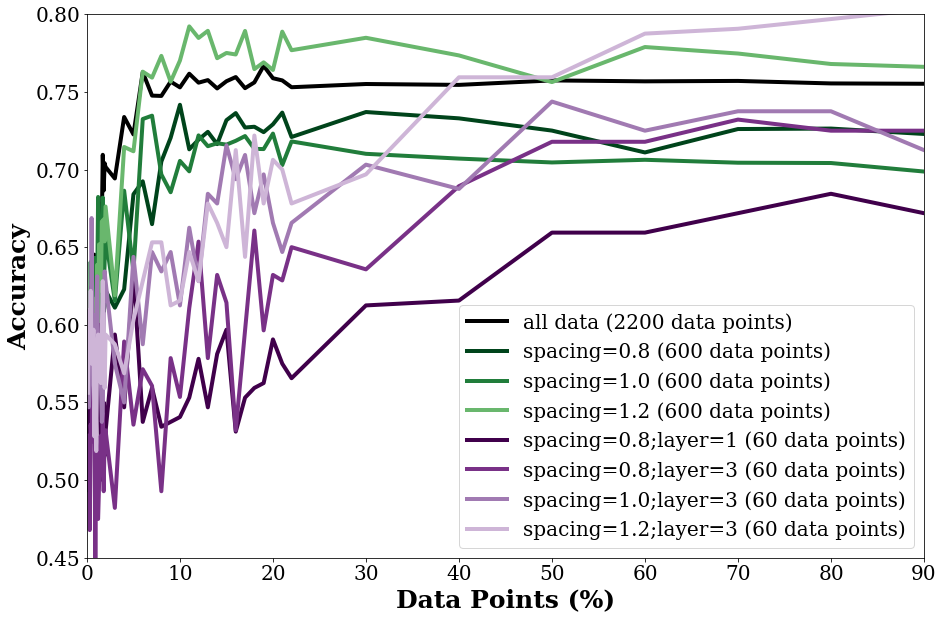

In [37]:
import matplotlib
spacings_s = ["spacing=0.8 (600 data points)", 
            "spacing=1.0 (600 data points)", "spacing=1.2 (600 data points)"]
spacings_sl = ["spacing=0.8;layer=1 (60 data points)",
            "spacing=0.8;layer=3 (60 data points)",
            "spacing=1.0;layer=3 (60 data points)",
            "spacing=1.2;layer=3 (60 data points)"]
#X axis
proc_data = [0.001+i*0.001 for i in range(20)]
proc_data.extend([0.03+i*0.01 for i in range(20)])
proc_data.extend([0.3+i*0.1 for i in range(8)])
#print([i*100 for i in proc_data])
proc_scaled = [i*100 for i in proc_data]
cmap = plt.cm.PRGn
colors_tmp= cmap(np.linspace(0,1,10))
colors = [colors_tmp[-1], colors_tmp[-2], colors_tmp[-3]]
          #colors_tmp[0], colors_tmp[1], colors_tmp[2], colors_tmp[3]]
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('text', usetex=False)
matplotlib.rc('font', **font)

#plt.grid(True)
plt.figure(figsize=(15,10))
plt.plot(proc_scaled, results_all, '-k', 
         label="all data (2200 data points)", 
         linewidth=4,
        alpha=1)

for i, res_all in enumerate(results_all_s):
    plt.plot(proc_scaled, res_all, '-', 
             label=spacings_s[i], 
             linewidth=4, alpha=1, color=colors[i])

colors_tmp= cmap(np.linspace(0,1,10))
#colors = #[colors_tmp[-1], colors_tmp[-2], colors_tmp[-3]]
colors = [colors_tmp[0], colors_tmp[1], colors_tmp[2], colors_tmp[3]]

for i, res_all in enumerate(results_all_sl):
    plt.plot(proc_scaled, res_all, '-', 
             label=spacings_sl[i], 
             linewidth=4, alpha=1, color=colors[i])


plt.ylabel('Accuracy', fontweight='bold', fontsize=25)
plt.xlabel('Data Points (%)', fontweight='bold', fontsize=25)
plt.xlim([0, 90])
plt.ylim([0.45, 0.8])
plt.legend()
plt.savefig("learning_curves3.eps", dpi=300)

## Plot the accuracies in the learning curve - B

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


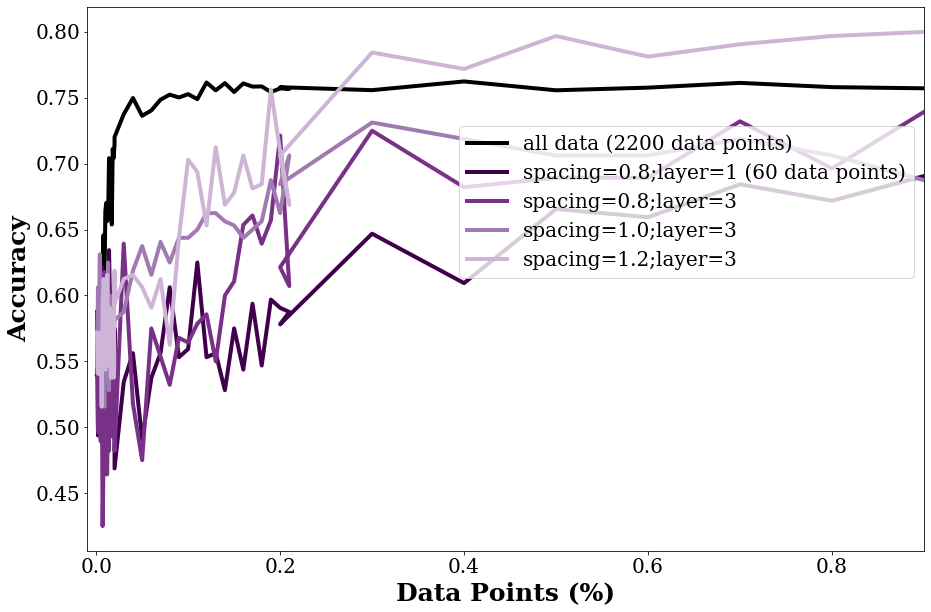

In [21]:
import matplotlib
spacings = ["spacing=0.8;layer=1 (60 data points)",
            "spacing=0.8;layer=3",
            "spacing=1.0;layer=3",
            "spacing=1.2;layer=3"]
#X axis
proc_data = [0.001+i*0.001 for i in range(20)]
proc_data.extend([0.02+i*0.01 for i in range(20)])
proc_data.extend([0.2+i*0.1 for i in range(8)])

cmap = plt.cm.PRGn
colors_tmp= cmap(np.linspace(0,1,10))
#colors = #[colors_tmp[-1], colors_tmp[-2], colors_tmp[-3]]
colors = [colors_tmp[0], colors_tmp[1], colors_tmp[2], colors_tmp[3]]
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('text', usetex=False)
matplotlib.rc('font', **font)

#plt.grid(True)
plt.figure(figsize=(15,10))
plt.plot(proc_data, results_all, '-k', 
         label="all data (2200 data points)", 
         linewidth=4,
        alpha=1)

for i, res_all in enumerate(results_all_sl):
    plt.plot(proc_data, res_all, '-', 
             label=spacings[i], 
             linewidth=4, alpha=1, color=colors[i])


plt.ylabel('Accuracy', fontweight='bold', fontsize=25)
plt.xlabel('Data Points (%)', fontweight='bold', fontsize=25)
plt.xlim([-0.01, 0.9])
plt.legend(loc=1, bbox_to_anchor=(1,0.8))
plt.savefig("learning_curves3.eps", dpi=300)

## Average across all configurations